In [0]:
import os
import shutil
import json
import re
import os
import datetime
from itertools import permutations 
import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive
import imageio
import glob
from PIL import Image
from functools import reduce
import skimage.measure

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter

dp = "/content/drive/My Drive/601R/"
dp_models = "/content/drive/My Drive/601R/project_1/models/"
dpn = "/content/drive/My Drive/601R/project_1/data/nuclei/"
dpm = "/content/drive/My Drive/601R/project_1/data/mice/"

In [7]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def condense_masks():
    """
        Image masks are sperated into n different images each with a Nuclei defined. 
        This function sums the images into one mask image to detect Nuclei

    """

    # folder paths 
    d = dp+"stage1_train/"
    d_labels = dp+"stage1_masks/"

    # loops through all the classes
    for o in os.listdir(d):
        img = None
        for im_path in glob.glob(d+o+"/masks/*.png"):
            if img is None:
                img = imageio.imread(im_path)
            else:
                img = img + imageio.imread(im_path)

        # creates folder, saves file and deletes individual masks 
        if not os.path.exists(d_labels+o):
            os.mkdir(d_labels+o)
        
        if img is not None:
            Image.fromarray(img).save(d_labels+"/"+o+"/"+o+".png")
            print("saved to",d_labels+o+"/"+o+".png")

        if os.path.exists(d+o+"/masks"):
            shutil.rmtree(d+o+"/masks")
            print("Deleted", d+o+"/masks")

In [0]:
# condense_masks()

In [0]:
class BYUMice(Dataset):

    def __init__(self,root=dpm, train=True, cell=1, n =256, count=False):
        """
        root : root folder for the images
        cell: int 1:"macrophages", 2:"lymphocytes", or 3:"PMN"
        """
        cell_dict = dict()
        cell_dict[1] = "macrophages"
        cell_dict[2] = "lymphocytes"
        cell_dict[3] = "PMN"
        self.cd = cell_dict

        self.count = count
        self.train = train
        self.cell = cell
        root = root +"train/" if train else root +"test/"
        self.root = root
        self.blank = torch.zeros((n,n))
        

        correct_orientation = lambda x: x if x.shape[0] == 4000 else np.transpose(x,(1, 0, 2))
        

        self.trans = transforms.Compose([correct_orientation,
                                         transforms.ToPILImage(),
                                    transforms.Resize((n,n)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                    ])
        self.mt  = transforms.Compose([correct_orientation,
                                       transforms.ToPILImage(),
                                    transforms.Resize((n,n)),
                                    transforms.ToTensor()])
        

        

        if count:
            files = np.array([[(o,f[:-4]) for f in os.listdir(root+o+"/") if re.match(r'[0-9]*[\-\_][0-9]*.JPG', f)] for o in os.listdir(root)])
            self.files = files
            print(files)
        else:
            # get labeled files based on cell type given
            files = np.array([[(o,f[:-4]) 
                                for f in os.listdir(root+o+"/"+self.cd[cell]+"/") if re.match(r'[0-9]*[\-\_][0-9]*.png', f)] 
                                    for o in os.listdir(root) if o != "test"])
            self.files = reduce(lambda x,y: x+y,files)

    def __getitem__(self,index):
        if self.count:
            print(self.files[index])
            if self.train:
                path = self.root+"train/"
            else:
                path = self.root+"test/"

            return [self.trans(imageio.imread(path+m[0]+"/"+m[1]+".JPG")) for m in self.files[index]]

        o,f = self.files[index]
        img = self.trans(imageio.imread(self.root+o+"/"+f+".JPG"))
        img_path = lambda i: self.root+o+"/"+self.cd[i]+"/"+f+".png"

        m = img_path(self.cell)
        mask = self.mt(imageio.imread(m))[0,:,:].squeeze()

        mask2 = torch.zeros_like(mask)
        for i in range(1,4):
            if i != self.cell and os.path.exists(img_path(i)):
                mask2 = mask2 + self.mt(imageio.imread(img_path(i)))[0,:,:].squeeze()

        if self.train:
            return img, mask, mask2
        elif not self.train:
            m = self.root+o+"/"+self.cd[self.cell]+"/"+f+".png"
            mask = self.mt(imageio.imread(m))[0,:,:].squeeze() if os.path.exists(m) else self.blank 
            return img, mask


    def __len__(self):
        return len(self.files)
        

In [0]:
Aclass Nuclei(Dataset):

    def __init__(self,root=dpn, train=True):

        self.train = train
        ds_root = root+"stage1_train" if train else root+"stage1_test/"

        n = 128
        

        trans = transforms.Compose([transforms.Resize((n,n)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                    ])
        
        label_trans = transforms.Compose([transforms.Resize((n,n)),
                                          transforms.Grayscale(),
                                    transforms.ToTensor(),
                                    ])
        
        self.dataset_folder = torchvision.datasets.ImageFolder(ds_root, transform = trans)

        if train:
            mask_root = root+"stage1_masks"
            self.mask_folder = torchvision.datasets.ImageFolder(mask_root, transform=label_trans)

    def __getitem__(self,index):
        img = self.dataset_folder[index]

        if self.train:
            mask = self.mask_folder[index]
            return img[0], mask[0][0]
        else:
            return img[0]

    def __len__(self):
        return len(self.dataset_folder)


In [0]:
n = Nuclei()
nt = Nuclei(train=False)

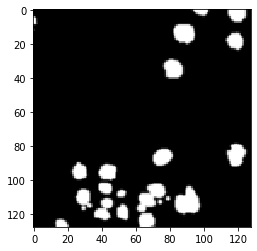

In [0]:
plt.imshow(n[0][1],cmap='gray')
plt.show()

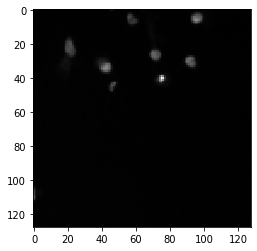

In [0]:
plt.imshow(nt[3][0,:,:],cmap='gray')
plt.show()

In [0]:
class TwoConv2d(nn.Module):
  def __init__(self, in_ch, out_ch):
    super(TwoConv2d, self).__init__()
    self.net = nn.Sequential(
        nn.BatchNorm2d(in_ch),
        nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(out_ch),
        nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1,padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU())
    
  def forward(self, input):
    return self.net(input)
  
  
class UpConv(nn.Module):
  def __init__(self, in_ch, out_ch):
    super(UpConv, self).__init__()
    self.up_conv = nn.Sequential(
        nn.BatchNorm2d(in_ch),
        nn.ConvTranspose2d(in_ch, out_ch, 4, 2, 1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU())
    
  def forward(self, input):
    return self.up_conv(input)

In [0]:
class CellDetector(nn.Module):

    def __init__(self):
        super(CellDetector, self).__init__()

        self.max_pool = nn.MaxPool2d(2)
        
        self.conv1 = TwoConv2d(3,64)
        self.conv2 = TwoConv2d(64,128)
        self.conv3 = TwoConv2d(128,256)
        self.conv4 = TwoConv2d(256,512)
        
        self.conv_bottom = TwoConv2d(512,1024)    
    
        self.up_conv4 = UpConv(1024,512)
        self.up_conv3 = UpConv(512,256)
        self.up_conv2 = UpConv(256,128)
        self.up_conv1 = UpConv(128,64)
        
        self.conv4_ = TwoConv2d(1024,512)
        self.conv3_ = TwoConv2d(512,256)
        self.conv2_ = TwoConv2d(256,128)
        self.conv1_ = TwoConv2d(128,64)
        
        self.final_conv = nn.Sequential(nn.Conv2d(64,2,1,1,0),
                                    nn.Sigmoid())

    def forward(self, x):
        # convolve down
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(self.max_pool(conv1_out))
        conv3_out = self.conv3(self.max_pool(conv2_out))
        conv4_out = self.conv4(self.max_pool(conv3_out))
        
        # flatten all the way out at the 'bottom' of the U-Net
        conv_bottom_out = self.conv_bottom(self.max_pool(conv4_out))
        
        # convolve back up with the output from the convolutions tacked on. 
        conv4__out = self.conv4_(torch.cat((self.up_conv4(conv_bottom_out), conv4_out), 1))
        conv3__out = self.conv3_(torch.cat((self.up_conv3(conv4__out), conv3_out), 1))
        conv2__out = self.conv2_(torch.cat((self.up_conv2(conv3__out), conv2_out), 1))
        conv1__out = self.conv1_(torch.cat((self.up_conv1(conv2__out), conv1_out), 1))

        out = self.final_conv(conv1__out)
        return out



In [0]:
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin=.5, alpha=3, beta=0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.a = alpha
        self.b = beta

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = nn.CrossEntropyLoss()(anchor, positive) #(anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = nn.CrossEntropyLoss()(anchor, negative) #(anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(self.a*distance_positive - self.b*distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

In [0]:
def train_rnn(model, path, dataset, epochs, batch_size, lr, loss):
        
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model = model.cuda()
    
    if loss is "std":
        loss_func = nn.CrossEntropyLoss()
    else:
        loss_func = TripletLoss()
        
    loader = DataLoader(dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
    
    e_losses = []
    
    for e in range(epochs):
    
        losses = []

        for i, data in enumerate(loader):
            if loss is "std":
                x, y = data
            
            else:
                x, y, y_ = data
                y_ = y_.cuda().long()

            y = y.cuda().long()
            x = x.cuda()

            y_hat = model(x)

            if loss is "std":
                loss = loss_func(y_hat, y)
            else:
                loss = loss_func(y_hat, y, y_, size_average=False)
            
            loss.backward()
            
            losses.append(loss.cpu().item())
            
            optimizer.step()
            
            if i % 30 == 0:
                print("Batch", i)
                print("Loss:", np.mean(losses))

        plt.imshow(y.cpu()[0,:,:],cmap='gray')
        plt.title("Positive Mask")
        plt.show()

        plt.imshow(y_.cpu()[0,:,:],cmap='gray')
        plt.title("Negative Mask")
        plt.show()

        y_hat_ = y_hat.cpu().detach()
        y_hat_[y_hat >= .1] = 1
        y_hat_[y_hat < .1] = 0
        plt.imshow(y_hat_[0,1,:,:],cmap='gray')
        plt.title("Predicted")
        plt.show()


        torch.save(model.state_dict(), path)
        e_losses.append(np.mean(losses))
        print("--------Epoch ", e ,"---------")

    return model, e_losses

In [0]:
def plot_loss(filename, losses):
    
    plt.plot(range(len(losses)), losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    
    plt.savefig( filename + "_loss.jpg")
    plt.show()
    
    return

In [0]:
def main(model_path, dataset, epochs=1, batch_size=1,  lr=.001, loss="std"):

    path = dp_models+model_path
    if os.path.exists(path):
        model = CellDetector()
        model.load_state_dict(torch.load(path))
    else:
        model = CellDetector()

    model, e_losses = train_rnn(model, path, dataset, epochs, batch_size, lr, loss)
    

    torch.save(model.state_dict(), path)
    # plot
    plot_loss(path, e_losses)

    return model

Batch 0
Loss: 1.3321895599365234
Batch 30
Loss: 1.2957658152426443
Batch 60
Loss: 1.2725951886567912


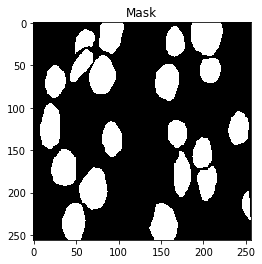

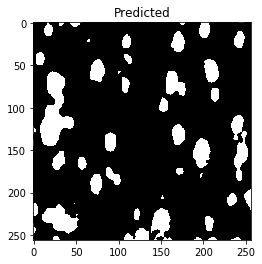

--------Epoch  0 ---------
Batch 0
Loss: 1.1864290237426758
Batch 30
Loss: 1.235015953740766
Batch 60
Loss: 1.2262680276495512


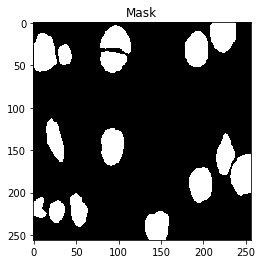

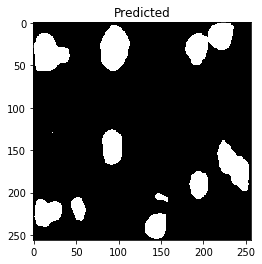

--------Epoch  1 ---------
Batch 0
Loss: 1.1485373973846436
Batch 30
Loss: 1.1961796745177238
Batch 60
Loss: 1.200153745588709


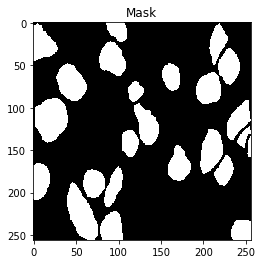

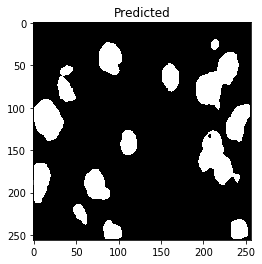

--------Epoch  2 ---------
Batch 0
Loss: 1.213862419128418
Batch 30
Loss: 1.214936867836983
Batch 60
Loss: 1.2025784156361565


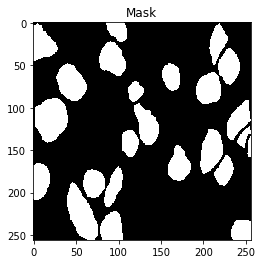

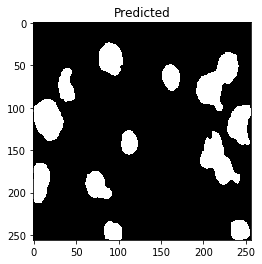

--------Epoch  3 ---------
Batch 0
Loss: 1.156733512878418
Batch 30
Loss: 1.2107283376878308
Batch 60
Loss: 1.1925217753551045


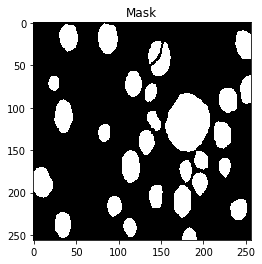

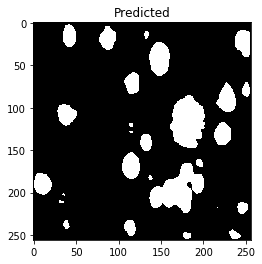

--------Epoch  4 ---------
Batch 0
Loss: 1.1512658596038818
Batch 30
Loss: 1.1931691362011818
Batch 60
Loss: 1.191673921757057


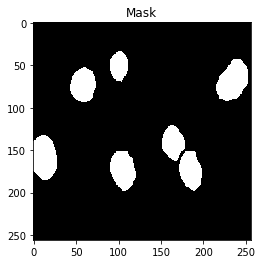

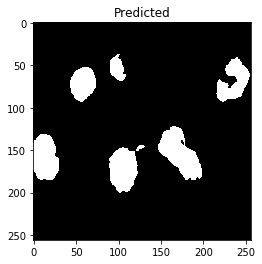

--------Epoch  5 ---------
Batch 0
Loss: 1.1563501358032227
Batch 30
Loss: 1.1840681798996464
Batch 60
Loss: 1.1904586084553452


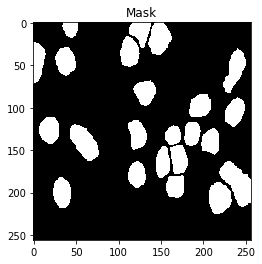

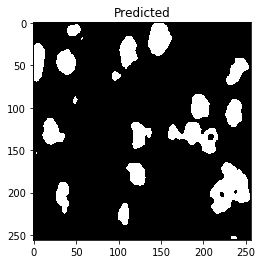

--------Epoch  6 ---------
Batch 0
Loss: 1.131598949432373
Batch 30
Loss: 1.2055921246928554
Batch 60
Loss: 1.1960750310147394


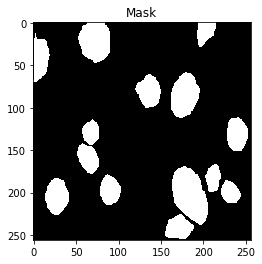

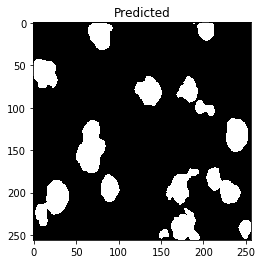

--------Epoch  7 ---------
Batch 0
Loss: 1.1235921382904053
Batch 30
Loss: 1.208923755153533
Batch 60
Loss: 1.2094225277666186


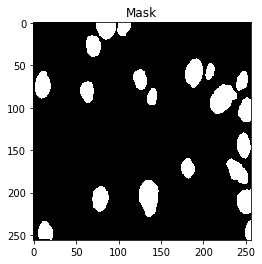

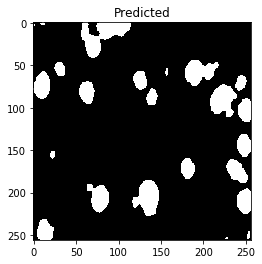

--------Epoch  8 ---------
Batch 0
Loss: 1.4298593997955322
Batch 30
Loss: 1.1869287683117775
Batch 60
Loss: 1.1870303505756816


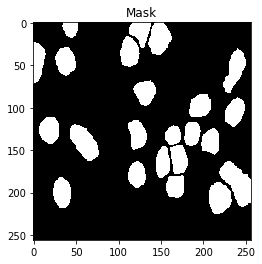

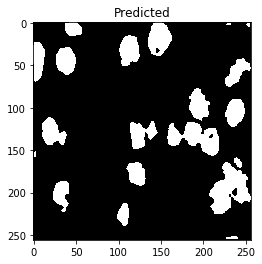

--------Epoch  9 ---------
Batch 0
Loss: 1.2075378894805908
Batch 30
Loss: 1.1955079993894022
Batch 60
Loss: 1.200185936005389


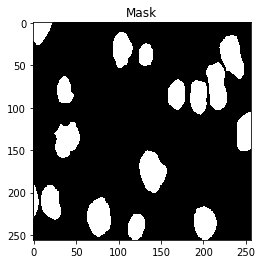

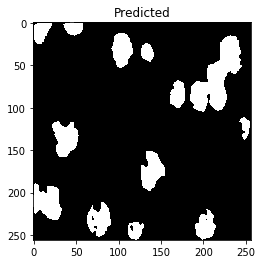

--------Epoch  10 ---------
Batch 0
Loss: 1.1533595323562622
Batch 30
Loss: 1.1955866044567478
Batch 60
Loss: 1.1995511172247715


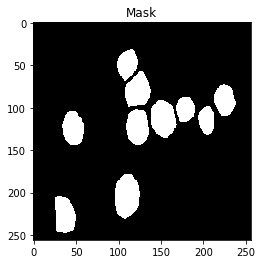

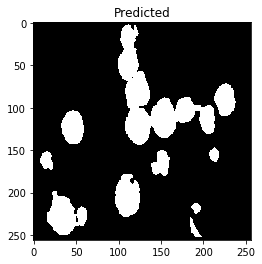

--------Epoch  11 ---------
Batch 0
Loss: 1.1528408527374268
Batch 30
Loss: 1.1921729195502497
Batch 60
Loss: 1.192768536630224


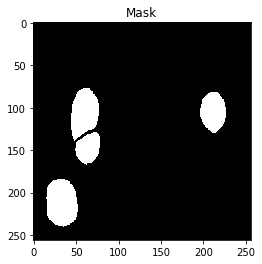

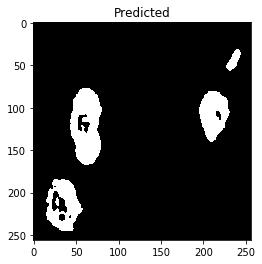

--------Epoch  12 ---------
Batch 0
Loss: 1.1479268074035645
Batch 30
Loss: 1.1834273953591623
Batch 60
Loss: 1.1913727287386284


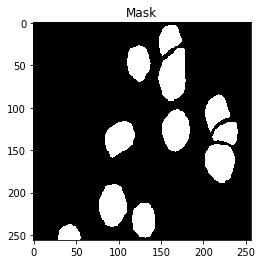

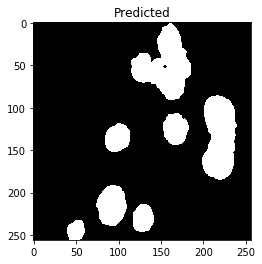

--------Epoch  13 ---------
Batch 0
Loss: 1.1929335594177246
Batch 30
Loss: 1.2067010594952492
Batch 60
Loss: 1.196091468216943


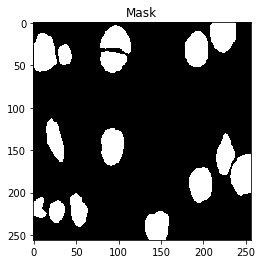

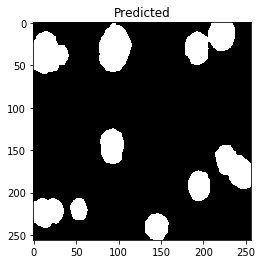

--------Epoch  14 ---------
Batch 0
Loss: 1.260612964630127
Batch 30
Loss: 1.1920424892056374
Batch 60
Loss: 1.191946512362996


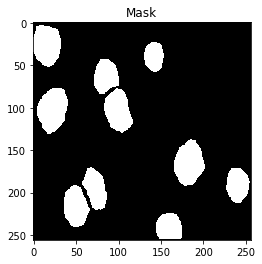

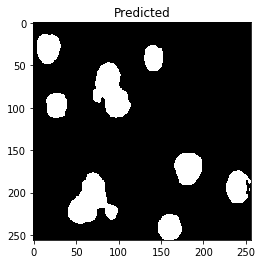

--------Epoch  15 ---------
Batch 0
Loss: 1.226020336151123
Batch 30
Loss: 1.2008458798931492
Batch 60
Loss: 1.1968281679466122


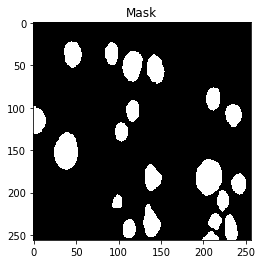

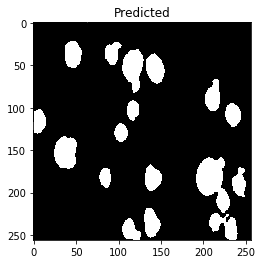

--------Epoch  16 ---------
Batch 0
Loss: 1.1833860874176025
Batch 30
Loss: 1.1810413022195139
Batch 60
Loss: 1.18327452901934


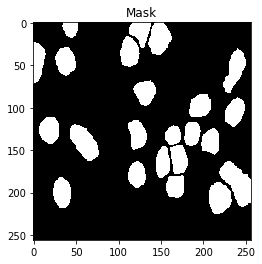

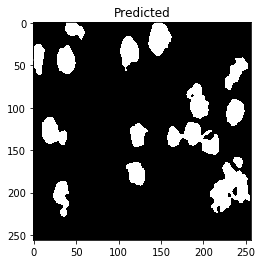

--------Epoch  17 ---------
Batch 0
Loss: 1.2940785884857178
Batch 30
Loss: 1.186597801023914
Batch 60
Loss: 1.1895527663778087


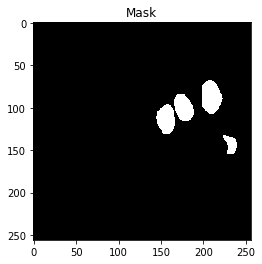

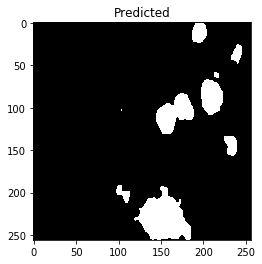

--------Epoch  18 ---------
Batch 0
Loss: 1.2362003326416016
Batch 30
Loss: 1.1984922616712508
Batch 60
Loss: 1.1875180201452287


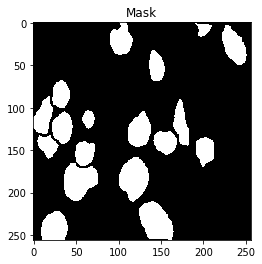

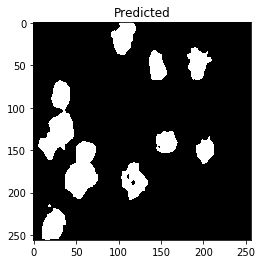

--------Epoch  19 ---------
Batch 0
Loss: 1.1369454860687256
Batch 30
Loss: 1.2040859422376078
Batch 60
Loss: 1.191607973614677


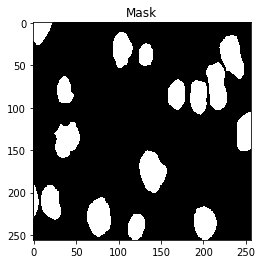

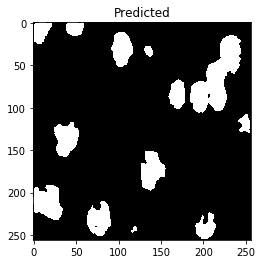

--------Epoch  20 ---------
Batch 0
Loss: 1.1266111135482788
Batch 30
Loss: 1.21120624772964
Batch 60
Loss: 1.1885970909087384


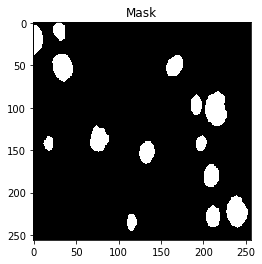

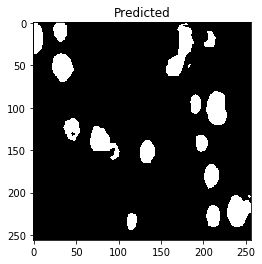

--------Epoch  21 ---------
Batch 0
Loss: 1.192352533340454
Batch 30
Loss: 1.1861373762930594
Batch 60
Loss: 1.1847709827735775


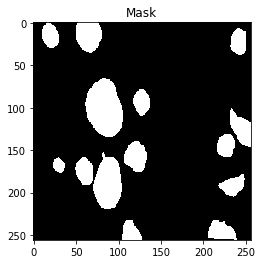

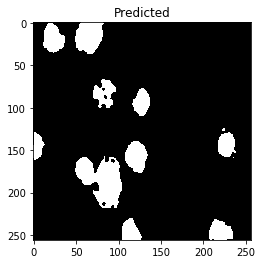

--------Epoch  22 ---------
Batch 0
Loss: 1.2757662534713745
Batch 30
Loss: 1.1974468231201172
Batch 60
Loss: 1.1857607345112036


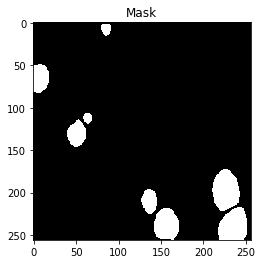

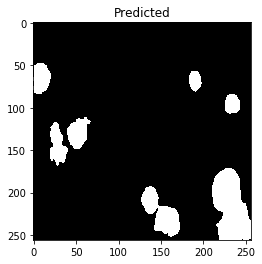

--------Epoch  23 ---------
Batch 0
Loss: 1.2454416751861572
Batch 30
Loss: 1.1758248306089831
Batch 60
Loss: 1.1745751334018395


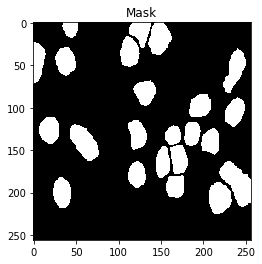

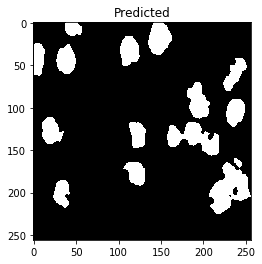

--------Epoch  24 ---------
Batch 0
Loss: 1.1310803890228271
Batch 30
Loss: 1.1771274305159045
Batch 60
Loss: 1.1810793055862676


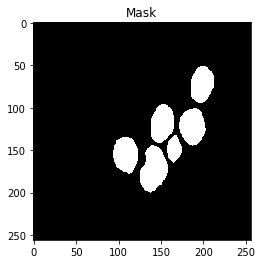

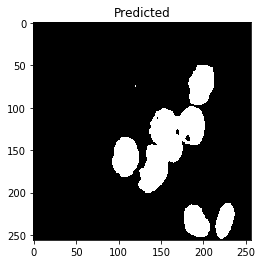

--------Epoch  25 ---------
Batch 0
Loss: 1.1505826711654663
Batch 30
Loss: 1.1778848094324912
Batch 60
Loss: 1.179668143147328


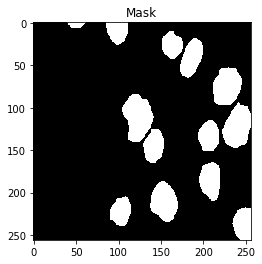

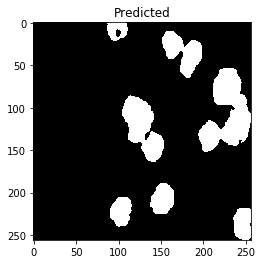

--------Epoch  26 ---------
Batch 0
Loss: 1.1403672695159912
Batch 30
Loss: 1.165671694663263
Batch 60
Loss: 1.1815619839996587


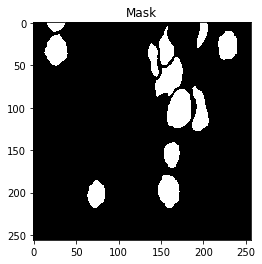

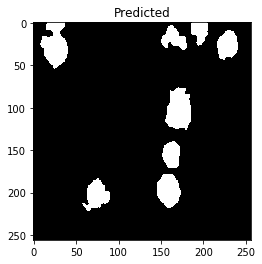

--------Epoch  27 ---------
Batch 0
Loss: 1.3554033041000366
Batch 30
Loss: 1.1790039808519426
Batch 60
Loss: 1.1803731351602273


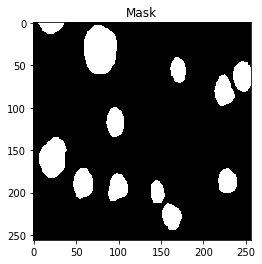

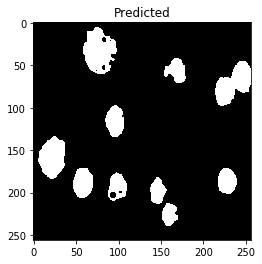

--------Epoch  28 ---------
Batch 0
Loss: 1.1306016445159912
Batch 30
Loss: 1.180352207153074
Batch 60
Loss: 1.1790089509526238


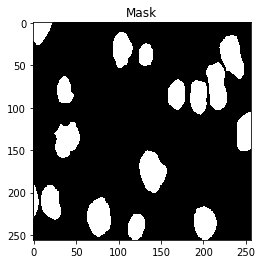

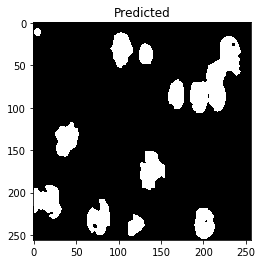

--------Epoch  29 ---------
Batch 0
Loss: 1.1345527172088623
Batch 30
Loss: 1.1875308559786888
Batch 60
Loss: 1.1770080171647619


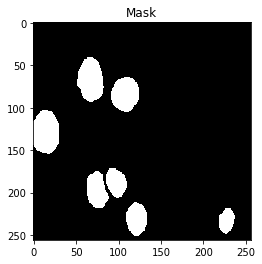

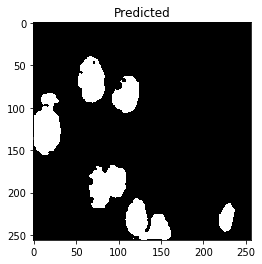

--------Epoch  30 ---------
Batch 0
Loss: 1.158928394317627
Batch 30
Loss: 1.1723799244050057
Batch 60
Loss: 1.1810756140067928


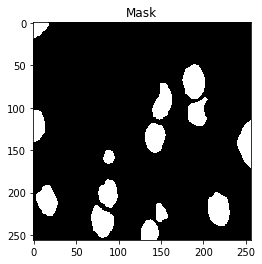

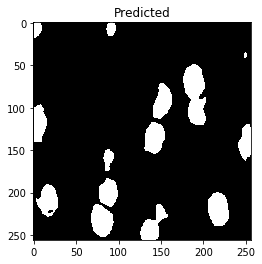

--------Epoch  31 ---------
Batch 0
Loss: 1.403824806213379
Batch 30
Loss: 1.1905414019861529
Batch 60
Loss: 1.1819010894806659


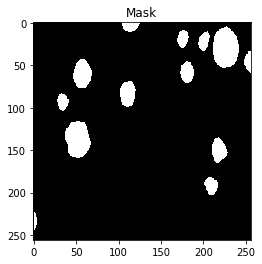

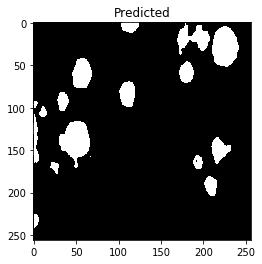

--------Epoch  32 ---------
Batch 0
Loss: 1.2643887996673584
Batch 30
Loss: 1.184530088978429
Batch 60
Loss: 1.1803557990027256


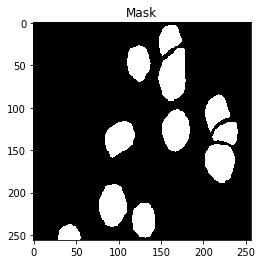

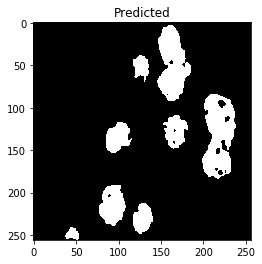

--------Epoch  33 ---------
Batch 0
Loss: 1.2264394760131836
Batch 30
Loss: 1.1908263583337106
Batch 60
Loss: 1.175054497406131


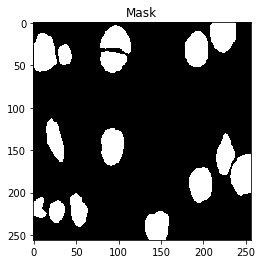

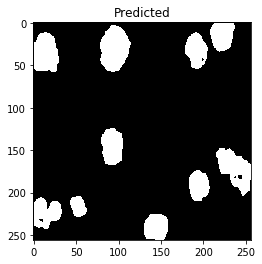

--------Epoch  34 ---------
Batch 0
Loss: 1.1266776323318481
Batch 30
Loss: 1.1783343361270042
Batch 60
Loss: 1.1800810040020553


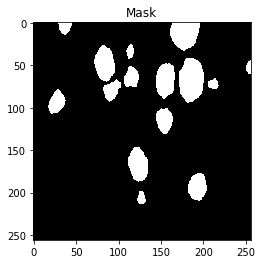

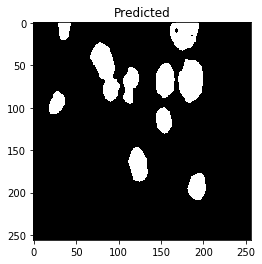

--------Epoch  35 ---------
Batch 0
Loss: 1.2247692346572876
Batch 30
Loss: 1.1813263316308298
Batch 60
Loss: 1.1742758438235423


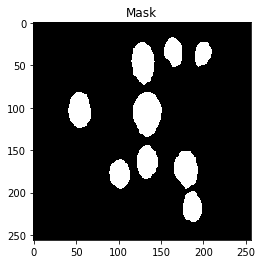

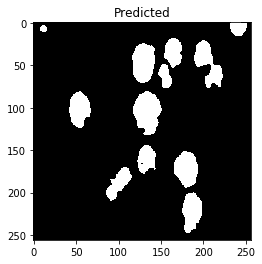

--------Epoch  36 ---------
Batch 0
Loss: 1.1279016733169556
Batch 30
Loss: 1.1810669360622283
Batch 60
Loss: 1.177911328487709


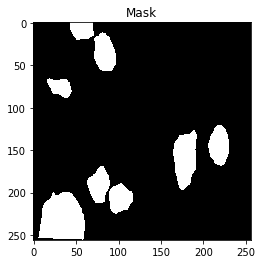

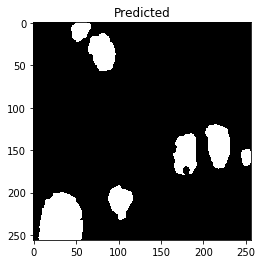

--------Epoch  37 ---------
Batch 0
Loss: 1.1258227825164795
Batch 30
Loss: 1.1637853653200212
Batch 60
Loss: 1.1712685100367812


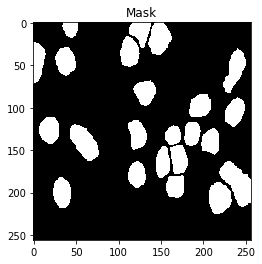

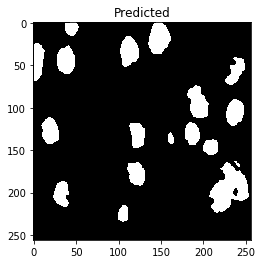

--------Epoch  38 ---------
Batch 0
Loss: 1.1363911628723145
Batch 30
Loss: 1.1768762911519697
Batch 60
Loss: 1.176033154862826


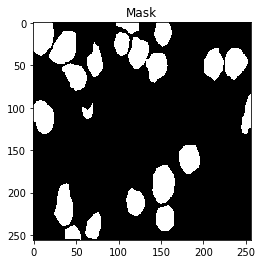

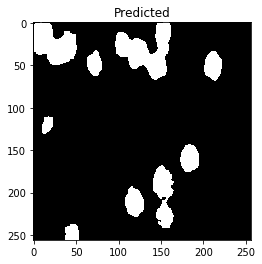

--------Epoch  39 ---------


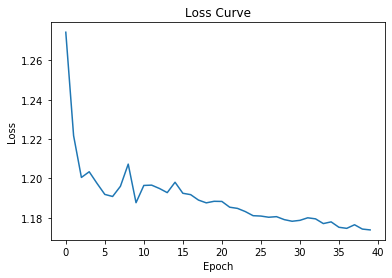

In [0]:
m = main("m_model.pt", epochs=40, dataset=BYUMice(), loss="custom")

Batch 0
Loss: 1.915640115737915
Batch 30
Loss: 1.6008005296030352


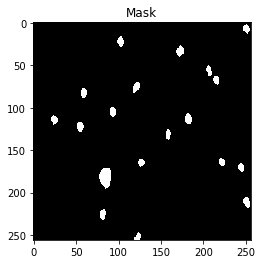

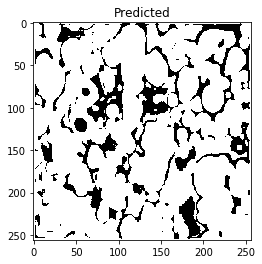

--------Epoch  0 ---------
Batch 0
Loss: 1.3039214611053467
Batch 30
Loss: 1.212460825520177


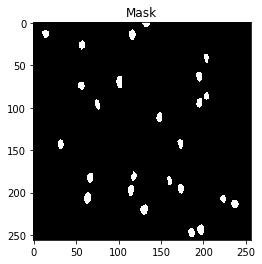

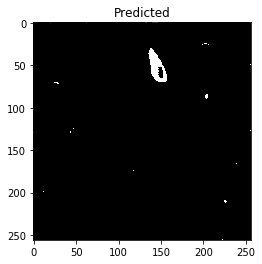

--------Epoch  1 ---------
Batch 0
Loss: 1.1441981792449951
Batch 30
Loss: 1.1208419992077736


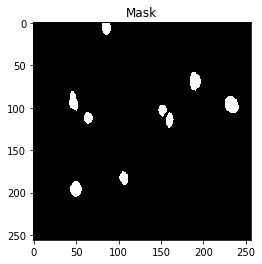

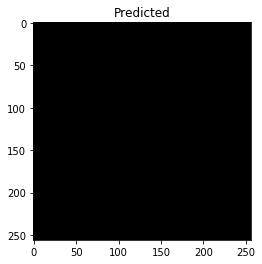

--------Epoch  2 ---------
Batch 0
Loss: 1.0922359228134155
Batch 30
Loss: 1.1149998826365317


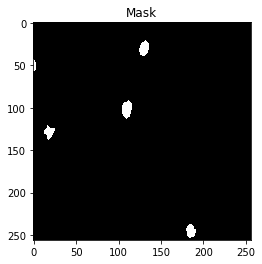

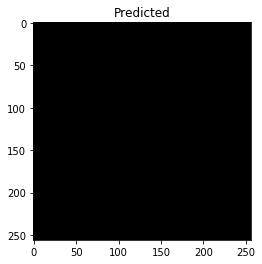

--------Epoch  3 ---------
Batch 0
Loss: 1.1551716327667236
Batch 30
Loss: 1.1133693187467513


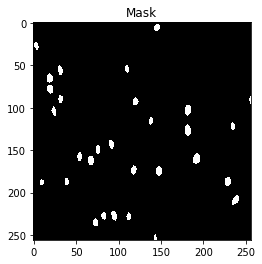

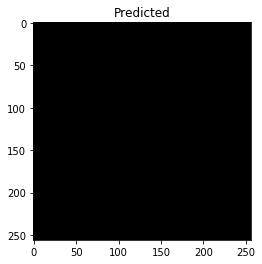

--------Epoch  4 ---------
Batch 0
Loss: 1.118525505065918
Batch 30
Loss: 1.1167598193691624


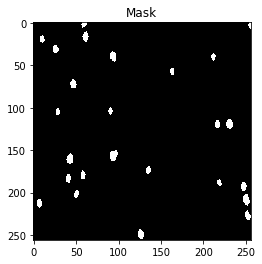

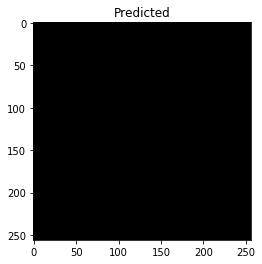

--------Epoch  5 ---------
Batch 0
Loss: 1.1276566982269287
Batch 30
Loss: 1.114258062454962


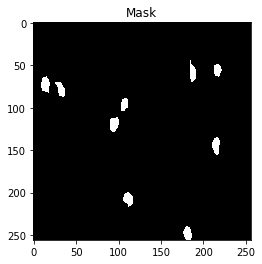

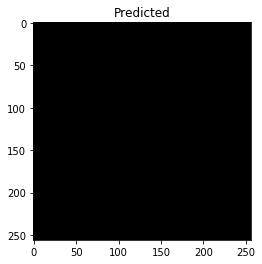

--------Epoch  6 ---------
Batch 0
Loss: 1.0985534191131592
Batch 30
Loss: 1.114098645025684


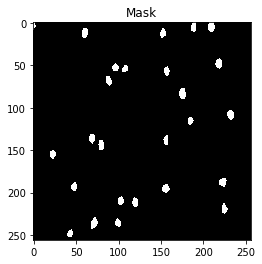

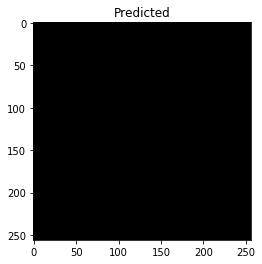

--------Epoch  7 ---------
Batch 0
Loss: 1.1550101041793823
Batch 30
Loss: 1.1158173853351223


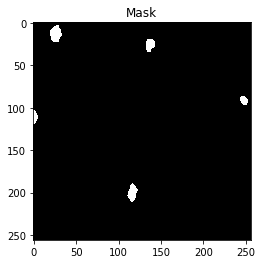

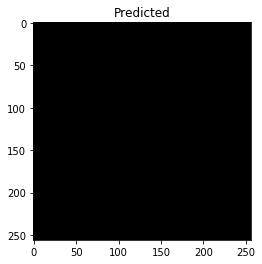

--------Epoch  8 ---------
Batch 0
Loss: 1.143192172050476
Batch 30
Loss: 1.1094083824465353


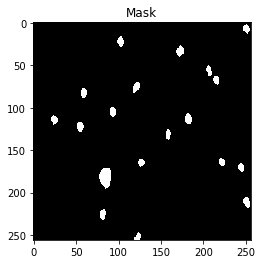

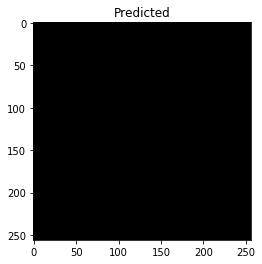

--------Epoch  9 ---------
Batch 0
Loss: 1.0861120223999023
Batch 30
Loss: 1.1144085930239769


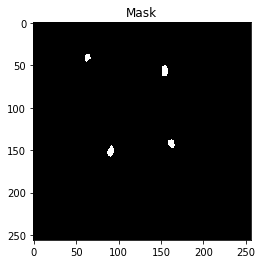

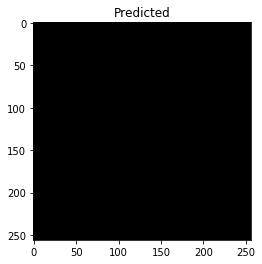

--------Epoch  10 ---------
Batch 0
Loss: 1.1216955184936523
Batch 30
Loss: 1.1153278581557735


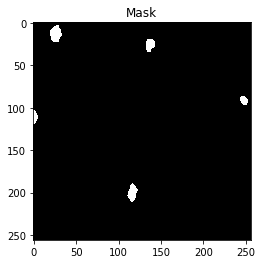

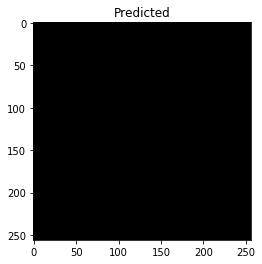

--------Epoch  11 ---------
Batch 0
Loss: 1.1306921243667603
Batch 30
Loss: 1.117841628289992


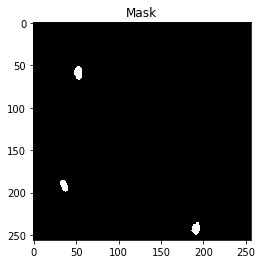

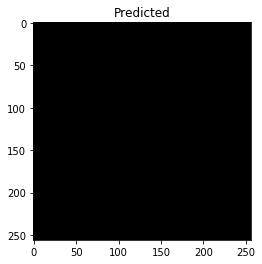

--------Epoch  12 ---------
Batch 0
Loss: 1.0823431015014648
Batch 30
Loss: 1.1127096030019945


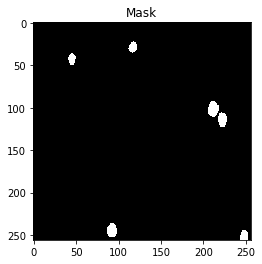

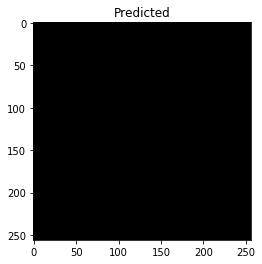

--------Epoch  13 ---------
Batch 0
Loss: 1.127657175064087
Batch 30
Loss: 1.1151436336578862


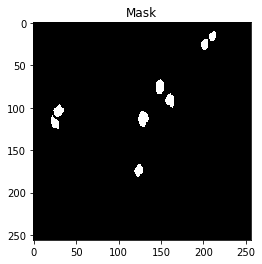

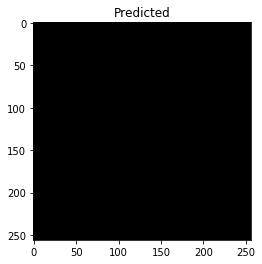

--------Epoch  14 ---------
Batch 0
Loss: 1.0954091548919678
Batch 30
Loss: 1.1143089148306078


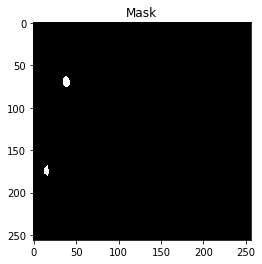

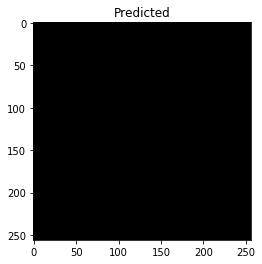

--------Epoch  15 ---------
Batch 0
Loss: 1.1274038553237915
Batch 30
Loss: 1.113604849384677


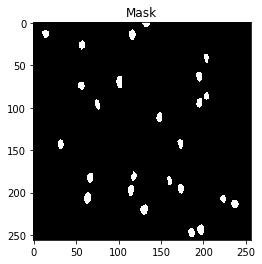

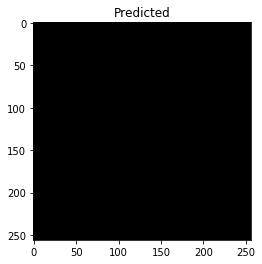

--------Epoch  16 ---------
Batch 0
Loss: 1.0823431015014648
Batch 30
Loss: 1.119141286419284


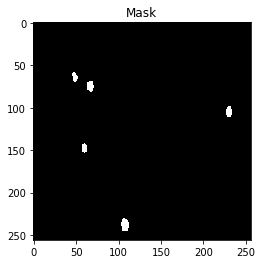

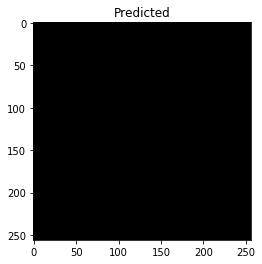

--------Epoch  17 ---------
Batch 0
Loss: 1.0950247049331665
Batch 30
Loss: 1.1140077844742806


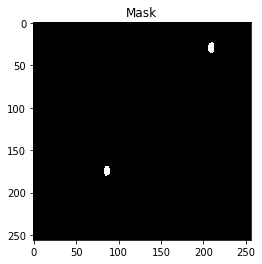

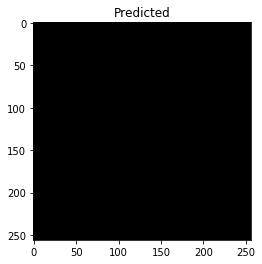

--------Epoch  18 ---------
Batch 0
Loss: 1.1240286827087402
Batch 30
Loss: 1.1142397119152931


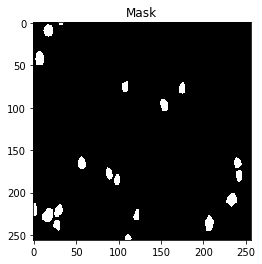

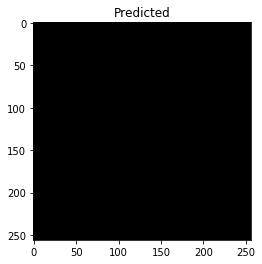

--------Epoch  19 ---------
Batch 0
Loss: 1.1012015342712402
Batch 30
Loss: 1.1160040286279493


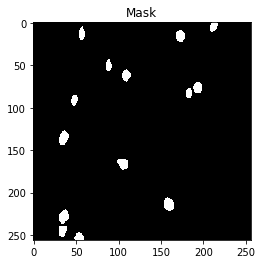

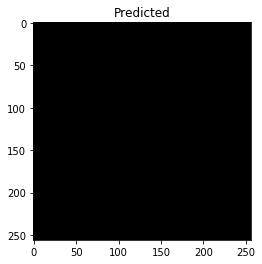

--------Epoch  20 ---------
Batch 0
Loss: 1.1240286827087402
Batch 30
Loss: 1.1128909818587764


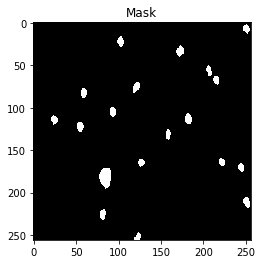

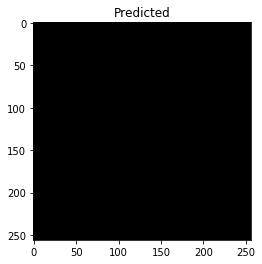

--------Epoch  21 ---------
Batch 0
Loss: 1.092378854751587
Batch 30
Loss: 1.1167452604539934


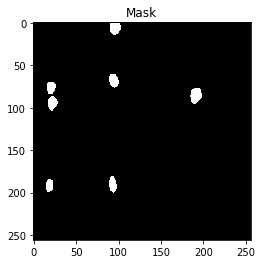

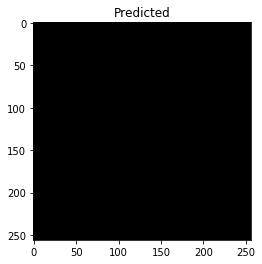

--------Epoch  22 ---------
Batch 0
Loss: 1.1550101041793823
Batch 30
Loss: 1.114266537850903


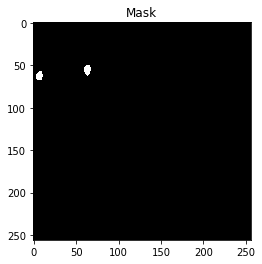

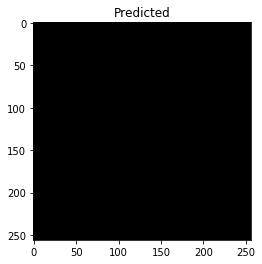

--------Epoch  23 ---------
Batch 0
Loss: 1.1257147789001465
Batch 30
Loss: 1.1156410940231816


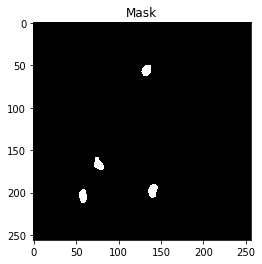

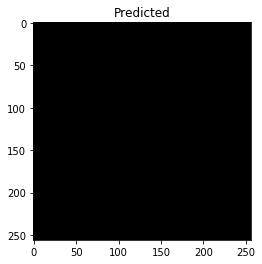

--------Epoch  24 ---------
Batch 0
Loss: 1.121768832206726
Batch 30
Loss: 1.1150630635599936


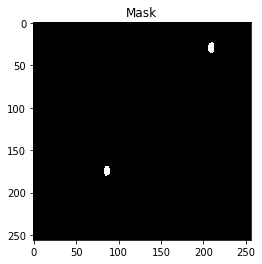

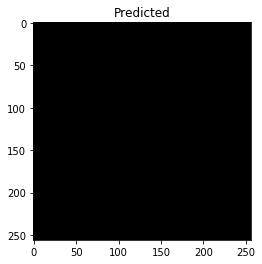

--------Epoch  25 ---------
Batch 0
Loss: 1.0918996334075928
Batch 30
Loss: 1.1093977459015385


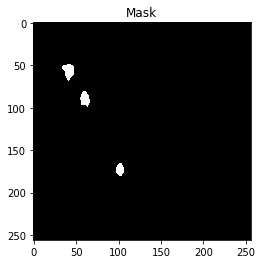

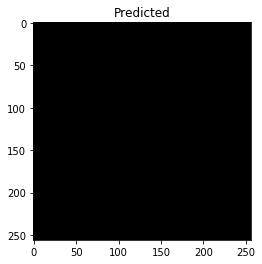

--------Epoch  26 ---------
Batch 0
Loss: 1.0944724082946777
Batch 30
Loss: 1.1154993003414524


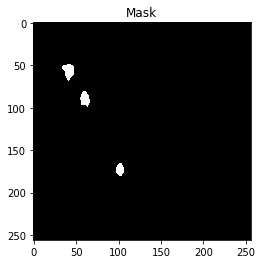

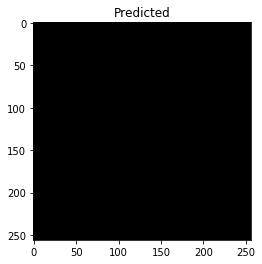

--------Epoch  27 ---------
Batch 0
Loss: 1.0823431015014648
Batch 30
Loss: 1.1129653530736123


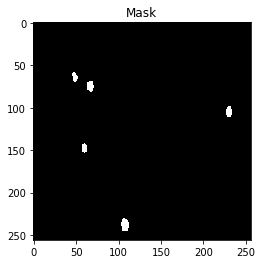

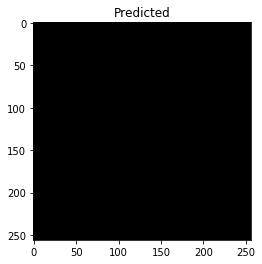

--------Epoch  28 ---------
Batch 0
Loss: 1.121768832206726
Batch 30
Loss: 1.1173955778921805


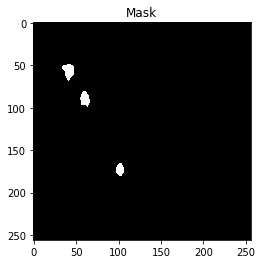

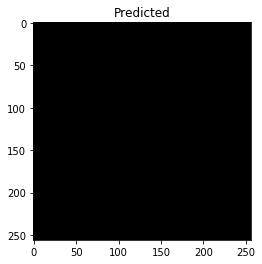

--------Epoch  29 ---------
Batch 0
Loss: 1.088086485862732
Batch 30
Loss: 1.1104695066328971


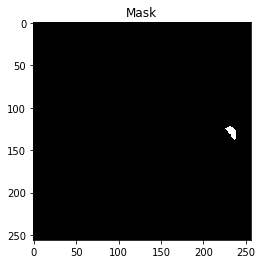

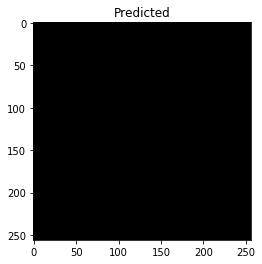

--------Epoch  30 ---------
Batch 0
Loss: 1.1306921243667603
Batch 30
Loss: 1.1127304223275953


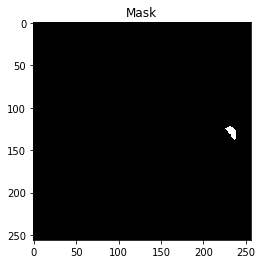

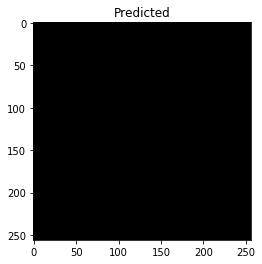

--------Epoch  31 ---------
Batch 0
Loss: 1.090970516204834
Batch 30
Loss: 1.1153240203857422


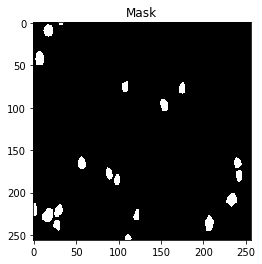

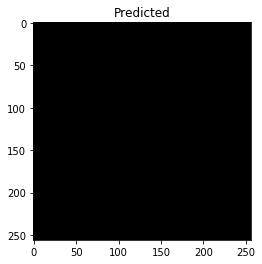

--------Epoch  32 ---------
Batch 0
Loss: 1.0984336137771606
Batch 30
Loss: 1.1144122308300388


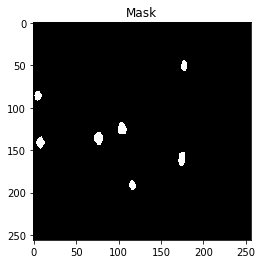

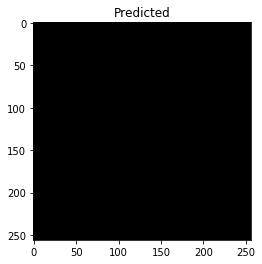

--------Epoch  33 ---------
Batch 0
Loss: 1.1143667697906494
Batch 30
Loss: 1.111602548630007


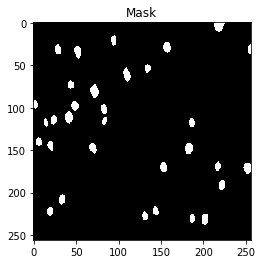

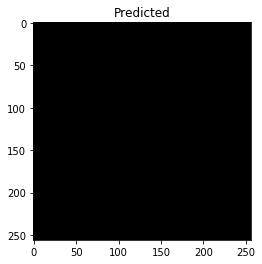

--------Epoch  34 ---------
Batch 0
Loss: 1.0985541343688965
Batch 30
Loss: 1.1150611754386657


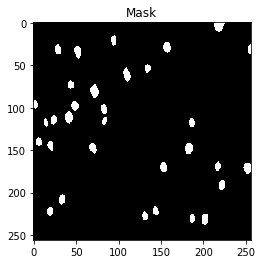

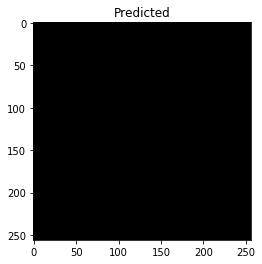

--------Epoch  35 ---------
Batch 0
Loss: 1.1523367166519165
Batch 30
Loss: 1.113266106574766


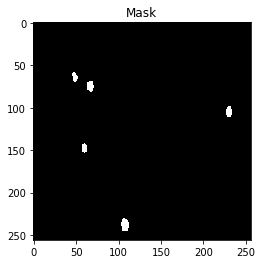

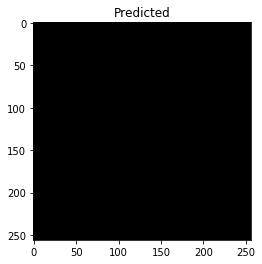

--------Epoch  36 ---------
Batch 0
Loss: 1.143192172050476
Batch 30
Loss: 1.116746837092984


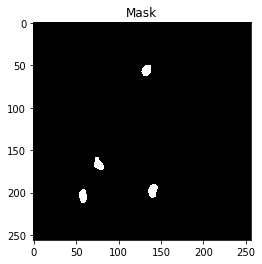

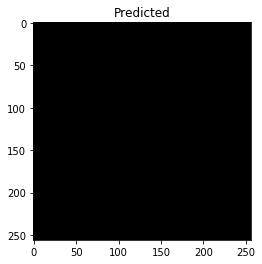

--------Epoch  37 ---------
Batch 0
Loss: 1.1185766458511353
Batch 30
Loss: 1.112840679384047


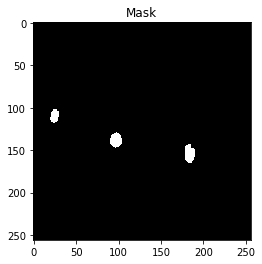

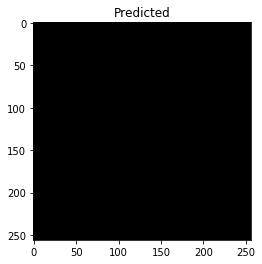

--------Epoch  38 ---------
Batch 0
Loss: 1.1550101041793823
Batch 30
Loss: 1.1126790738874865


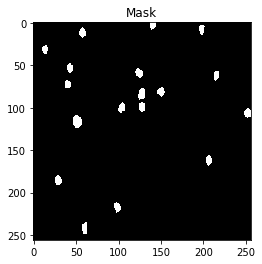

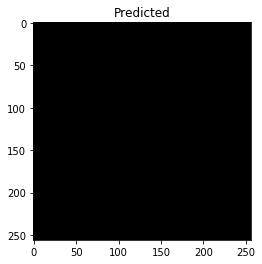

--------Epoch  39 ---------


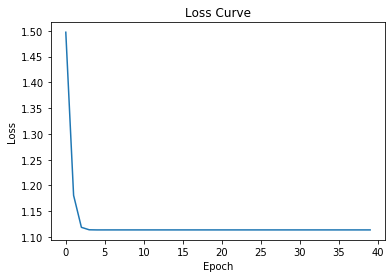

In [0]:
m = main("l_model.pt", epochs=40, dataset=BYUMice(cell=2), loss="custom")

Batch 0
Loss: 2.5217862129211426
Batch 30
Loss: 2.0833397796077113


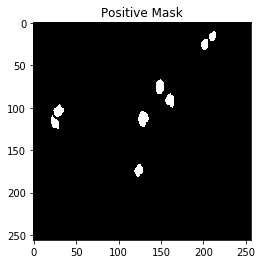

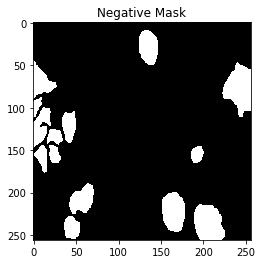

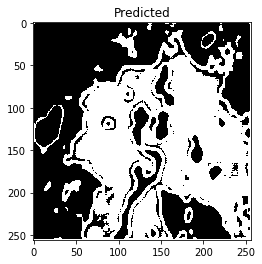

--------Epoch  0 ---------
Batch 0
Loss: 1.6526094675064087
Batch 30
Loss: 1.5966003594859954


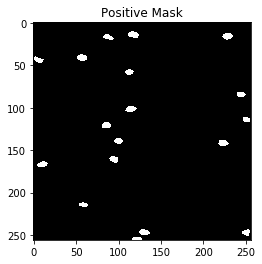

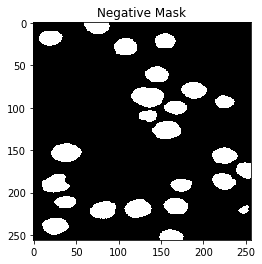

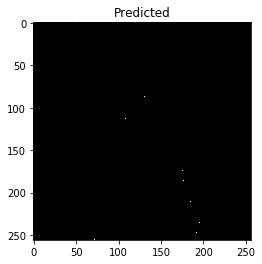

--------Epoch  1 ---------
Batch 0
Loss: 1.5250296592712402
Batch 30
Loss: 1.4960447396001508


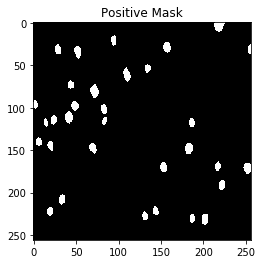

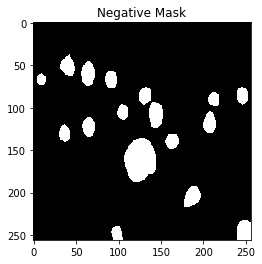

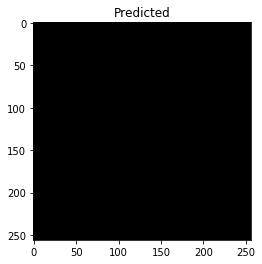

--------Epoch  2 ---------
Batch 0
Loss: 1.4531306028366089
Batch 30
Loss: 1.486014973732733


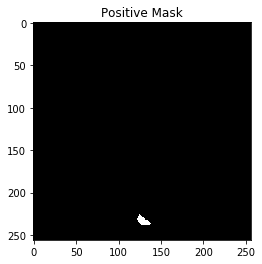

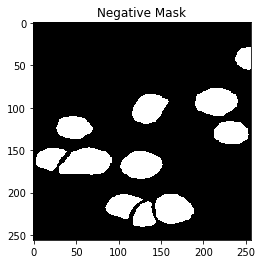

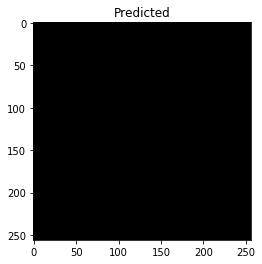

--------Epoch  3 ---------
Batch 0
Loss: 1.493475317955017
Batch 30
Loss: 1.4907270939119401


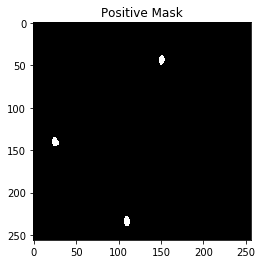

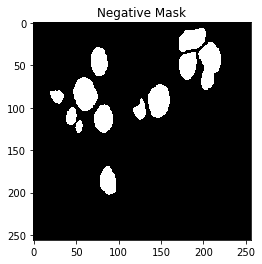

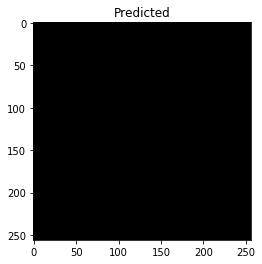

--------Epoch  4 ---------
Batch 0
Loss: 1.4729843139648438
Batch 30
Loss: 1.4843861249185377


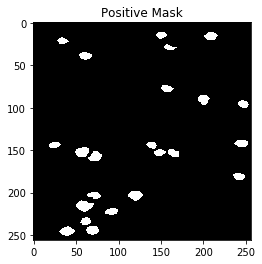

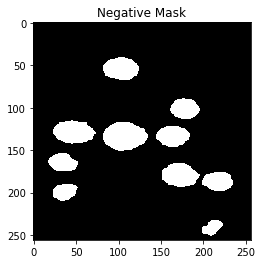

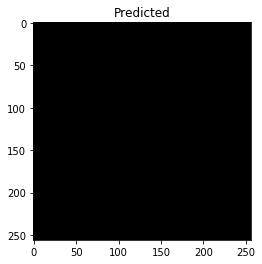

--------Epoch  5 ---------
Batch 0
Loss: 1.4492619037628174
Batch 30
Loss: 1.4888479440442977


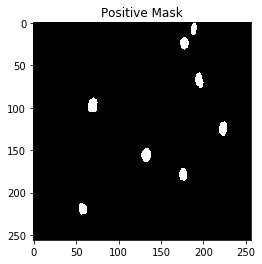

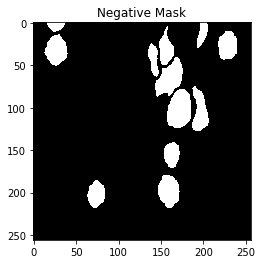

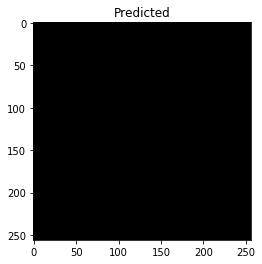

--------Epoch  6 ---------
Batch 0
Loss: 1.4461945295333862
Batch 30
Loss: 1.4850965469114241


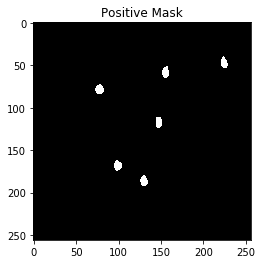

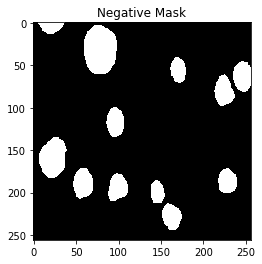

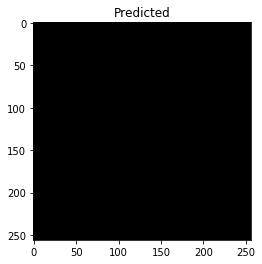

--------Epoch  7 ---------
Batch 0
Loss: 1.4982414245605469
Batch 30
Loss: 1.489278128070216


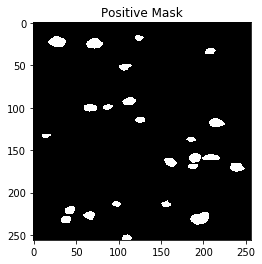

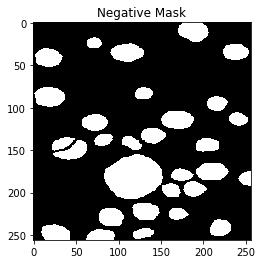

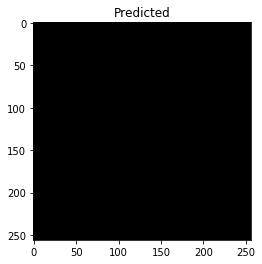

--------Epoch  8 ---------
Batch 0
Loss: 1.5520286560058594
Batch 30
Loss: 1.487128073169339


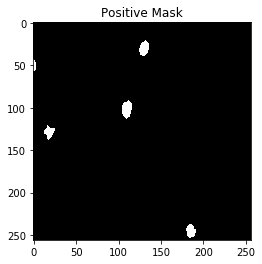

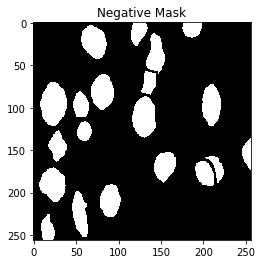

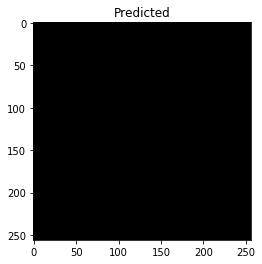

--------Epoch  9 ---------
Batch 0
Loss: 1.4680747985839844
Batch 30
Loss: 1.4873200385801253


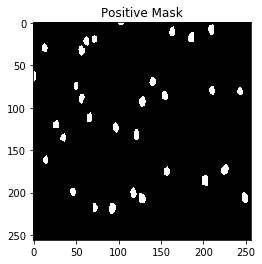

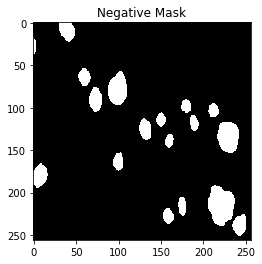

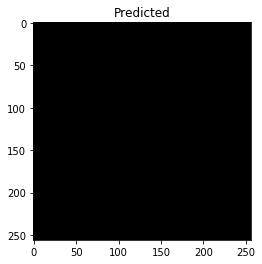

--------Epoch  10 ---------
Batch 0
Loss: 1.4704093933105469
Batch 30
Loss: 1.4847019295538626


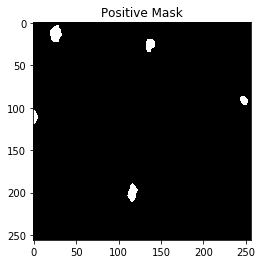

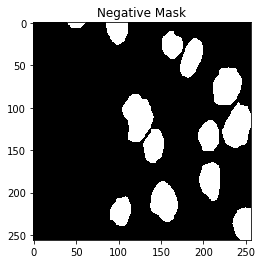

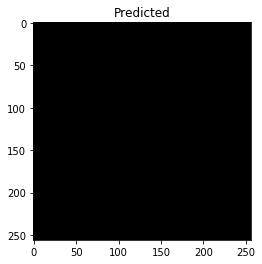

--------Epoch  11 ---------
Batch 0
Loss: 1.4489401578903198
Batch 30
Loss: 1.4900149376161638


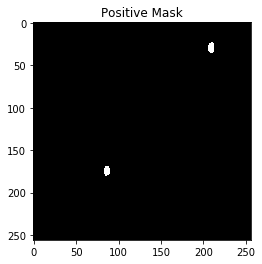

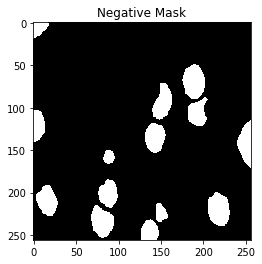

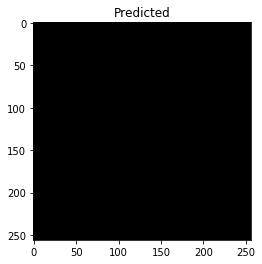

--------Epoch  12 ---------
Batch 0
Loss: 1.4952659606933594
Batch 30
Loss: 1.4938188060637443


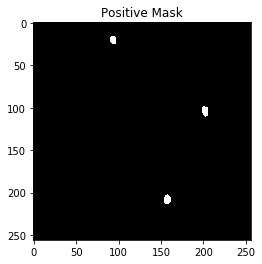

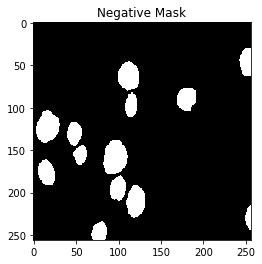

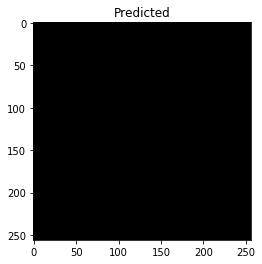

--------Epoch  13 ---------
Batch 0
Loss: 1.4446829557418823
Batch 30
Loss: 1.4862583183473157


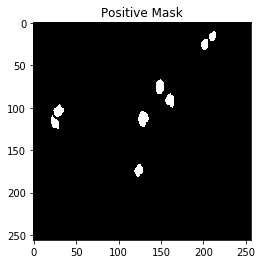

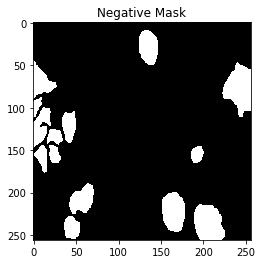

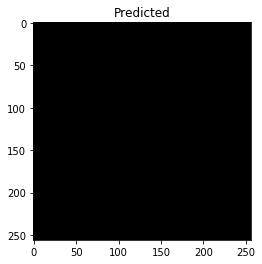

--------Epoch  14 ---------
Batch 0
Loss: 1.4547537565231323
Batch 30
Loss: 1.4881395793730212


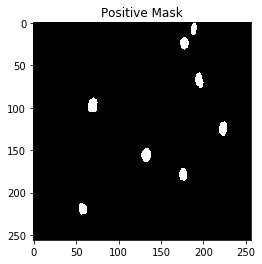

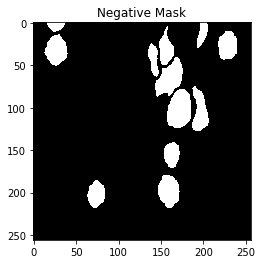

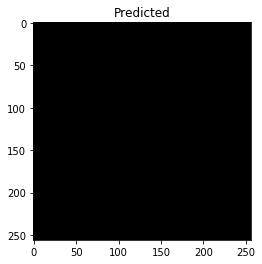

--------Epoch  15 ---------
Batch 0
Loss: 1.4750328063964844
Batch 30
Loss: 1.4894331270648586


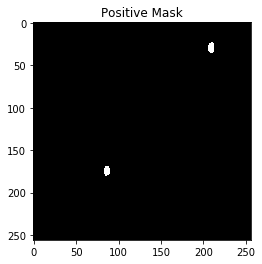

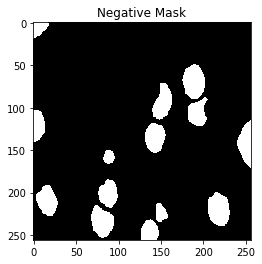

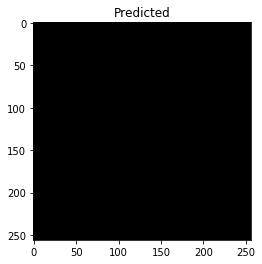

--------Epoch  16 ---------
Batch 0
Loss: 1.5306053161621094
Batch 30
Loss: 1.4905051954330937


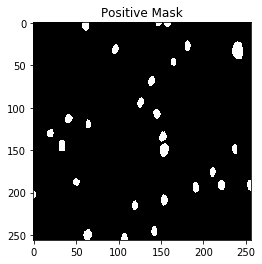

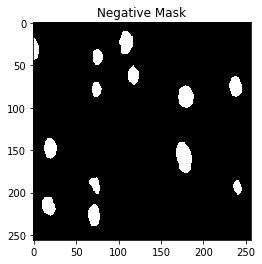

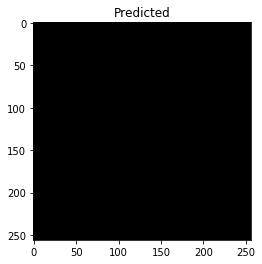

--------Epoch  17 ---------
Batch 0
Loss: 1.4756736755371094
Batch 30
Loss: 1.4886637964556295


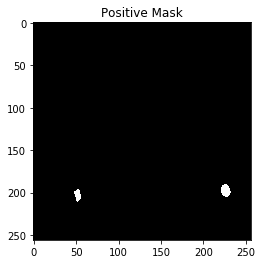

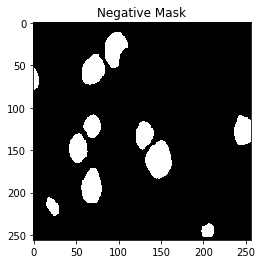

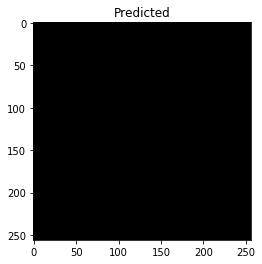

--------Epoch  18 ---------
Batch 0
Loss: 1.4547537565231323
Batch 30
Loss: 1.4834703899198962


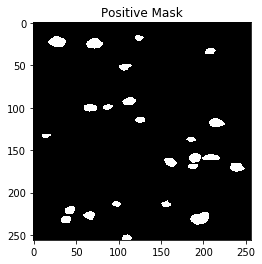

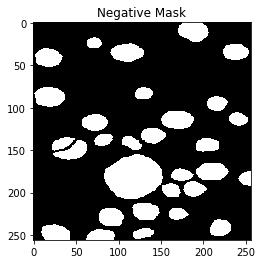

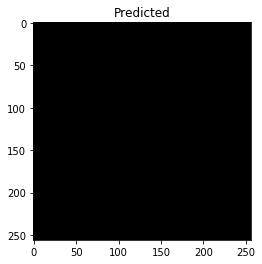

--------Epoch  19 ---------


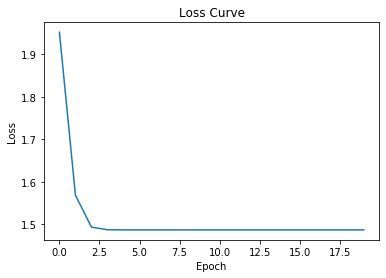

In [88]:
m = main("l2_model.pt", epochs=20, dataset=BYUMice(cell=2), loss="custom")

In [0]:
def test(model_path, dataset):

    path = dp_models+model_path

    if os.path.exists(path):
        model = CellDetector()
        model.load_state_dict(torch.load(path))
        model = model.cuda()
    else:
        raise ValueError("No Model named", model_path)

    val_loader = DataLoader(dataset, batch_size=1)

    for i, (img, y) in enumerate(val_loader):
        y_hat = model(img.cuda())

        plt.imshow(img[0,:,:,:].permute(1,2,0))
        plt.show()

        plt.imshow(y[0,:,:],cmap='gray')
        plt.title("Mask")
        plt.show()

        plt.imshow(y_hat.cpu().detach()[0,0,:,:],cmap='gray')
        plt.title("Predicted")
        plt.show()

        break


In [0]:
def count_components(img):
    return skimage.measure.label(img,return_num=True)[1]

In [0]:
def get_ratio(k):

    ratios = np.zeros((len(os.listdir(dpm)),3))

    # for each type of cell
    for i,m in enumerate(["m_model.pt","l_model.pt","p_model.pt"][:1]):
        path = dp_models+m
        model = CellDetector()
        model.load_state_dict(torch.load(path))
        model.eval()

        dataset = BYUMice(train=False, count=True)
        loader = DataLoader(dataset, batch_size=1, shuffle=False, pin_memory=True)

        with torch.no_grad():
            for j,imgs in enumerate(loader):
                cnt = 0
                for img in imgs:

                    y_hat = model(img)[0,1,:,:]
                    y_hat[y_hat >= .2] = 1
                    y_hat[y_hat < .2] = 0


                    plt.imshow(img[0,:,:,:].permute(1,2,0))
                    plt.title("Real Img")
                    plt.show()

                    plt.imshow(y_hat,cmap='gray')
                    plt.title("Predicted Mask")
                    plt.show()

                    cnt += count_components(y_hat)
                break
                ratios[j,i] = cnt

        ratios = (ratios.T / ratios.sum(axis=1)).T
        np.save(dp_models+"ratios"+k+".npy", ratios)
        return ratios
            

[list([('B60095(bleomycin)', '95_01'), ('B60095(bleomycin)', '95_02'), ('B60095(bleomycin)', '95_03'), ('B60095(bleomycin)', '95_04'), ('B60095(bleomycin)', '95_05'), ('B60095(bleomycin)', '95_06'), ('B60095(bleomycin)', '95_07'), ('B60095(bleomycin)', '95_08'), ('B60095(bleomycin)', '95_09'), ('B60095(bleomycin)', '95_10')])
 list([('B60111(bleomycin)', '111_1'), ('B60111(bleomycin)', '111_2'), ('B60111(bleomycin)', '111_3'), ('B60111(bleomycin)', '111_4'), ('B60111(bleomycin)', '111_5'), ('B60111(bleomycin)', '111_6'), ('B60111(bleomycin)', '111_7'), ('B60111(bleomycin)', '111_8'), ('B60111(bleomycin)', '111_9'), ('B60111(bleomycin)', '111_10'), ('B60111(bleomycin)', '111_11'), ('B60111(bleomycin)', '111_12'), ('B60111(bleomycin)', '111_13'), ('B60111(bleomycin)', '111_14'), ('B60111(bleomycin)', '111_15')])
 list([('B60113(non treated)', '113_01'), ('B60113(non treated)', '113_02'), ('B60113(non treated)', '113_03'), ('B60113(non treated)', '113_04'), ('B60113(non treated)', '113_05

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


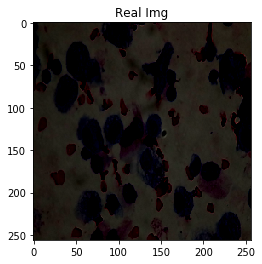

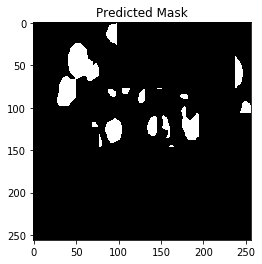

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


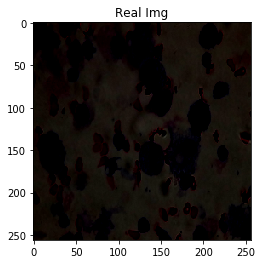

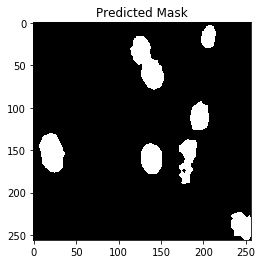

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


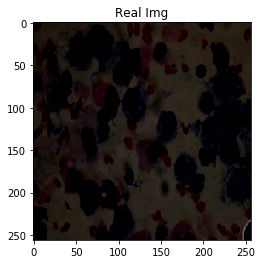

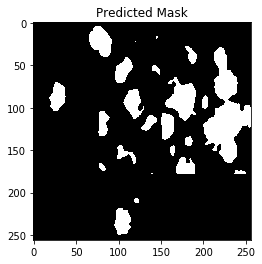

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


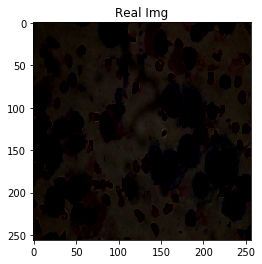

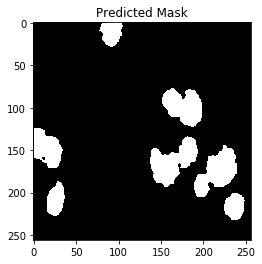

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


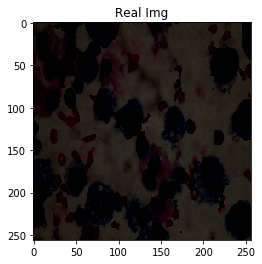

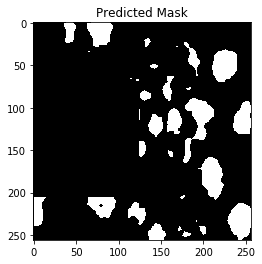

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


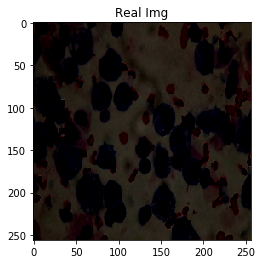

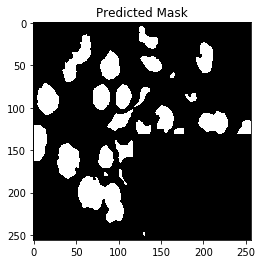

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


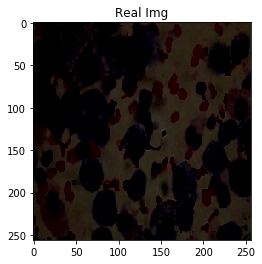

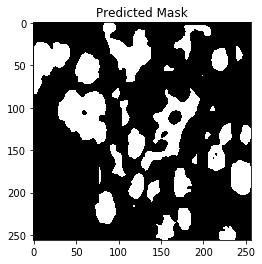

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


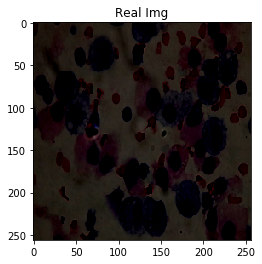

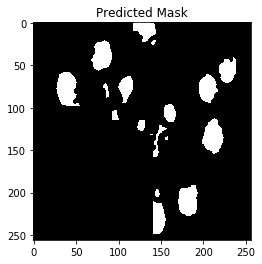

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


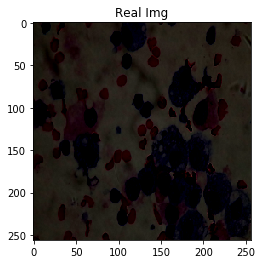

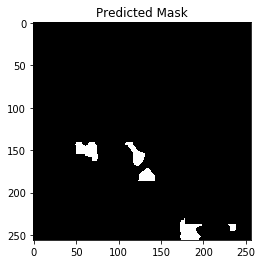

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


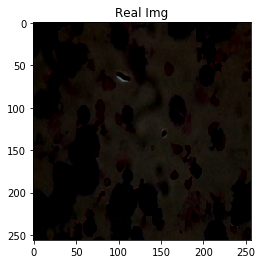

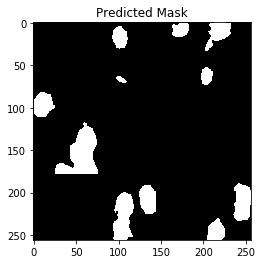

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


array([[nan, nan, nan],
       [nan, nan, nan]])

In [85]:
get_ratio("1")